In [16]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle
import json
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score
from sklearn import metrics


seed=117
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


## Protein Disorder Prediction

### Data set-up

Import drive, so that preprocessed data can be used in Notebook.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [3]:

def read_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_data.json', 'r') as infile:
    return json.load(infile)

def read_cleaned_pandas_data():
  return pd.read_json('/content/drive/My Drive/Colab Notebooks/diss_files/idr_pandas_table.json')

def read_onehot():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/onehot_data.json', 'r') as infile:
    onehot_map = json.load(infile)
    onehot_map.update((acc, np.array(onehot)) for acc, onehot in onehot_map.items())
    return onehot_map

def read_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_homo_solution():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/homo_solution.json', 'r') as infile:
    return json.load(infile)

# Protein sequences
protein_sequences_n_ids = read_sequences()
# IDRs
pandas_data_IDRs = read_cleaned_pandas_data()
# One-hot features
onehot_map = read_onehot()
# PSSM features
pssm_map = read_pssms()
# Randomly sampled dataset split from pre-processing.
# Data leakage prevention included.
non_leaking_dataset_split = read_homo_solution()

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [4]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = pandas_table
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        # Each row must have a unique accession number, hence we can 0 index this list
        dataframe_idx = self.disorder_prot.index[self.disorder_prot['acc'] == acc].tolist()[0]
        idrs = self.disorder_prot['disordered_regions'].loc[dataframe_idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [5]:
train_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_dataset = DisProtDataset(pandas_data_IDRs, onehot_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

train_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Train'])
validation_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Validation'])
test_pssm_dataset = DisProtDataset(pandas_data_IDRs, pssm_map, protein_sequences_n_ids, non_leaking_dataset_split['Test'])
train_pssm_loader = DataLoader(train_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
validation_pssm_loader = DataLoader(validation_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)
test_pssm_loader = DataLoader(test_pssm_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

### Loading PyTorch NN models.

In [6]:
class FCN_1D_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(20, 10, 21, padding=10)
        self.conv2 = nn.Conv1d(10, 10, 21, padding=10)
        self.conv3 = nn.Conv1d(10, 10, 21, padding=10)
        self.do1 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(10, 10, 21, padding=10)
        self.do2 = nn.Dropout(0.5)
        self.conv5 = nn.Conv1d(10, 1, 21, padding=10)
        self.do3 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.do1(F.relu(self.conv3(x)))
        x = self.do2(F.relu(self.conv4(x)))
        x = self.do3(self.conv5(x))
        # Removal of final activation function due to BCE With Logits Loss being used
        #x = torch.sigmoid(self.conv5(x))
        return x


class FCN_2D_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, (20, 21), padding=(0,10))
        self.conv2 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))
        self.conv3 = nn.Conv2d(1, 1, (1, 21), padding=(0,10))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = torch.sigmoid(self.conv3(x))
        x = self.conv3(x)
        return x


class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 20 inputs - for each amino acid
        self.input_dim = 20
        self.hidden_dim = 32
        self.num_layers = 2
        self.rnn1 = nn.LSTM(input_size=20, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim*2, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 1)
        #self.sig1 = nn.Sigmoid()

    def init_hidden(self, batch_size):
        # Initialise hidden state
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_dim), 
                torch.zeros(self.num_layers*2, batch_size, self.hidden_dim))

    def forward(self, x):
      batch_size = x.size(0)
      h    = self.init_hidden(batch_size)

      y, h = self.rnn1(x,h)
      y = self.relu1(self.linear(y))
      y = self.linear2(y)
      
      return y, h

#### Get saved trained models

In [7]:
# Reads trained model from storage
def read_model(model_class, model_name):
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/pth_files/'+model_name

  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(PATH))
  return loaded_model

cnn_1d_one_hot = read_model(FCN_1D_Net(), '1hot_1D_cnn_net.pth')
cnn_2d_one_hot = read_model(FCN_2D_Net(), '1hot_2D_cnn_net.pth')
cnn_1d_pssm = read_model(FCN_1D_Net(), 'pssm_1D_cnn_net.pth')
cnn_2d_pssm = read_model(FCN_2D_Net(), 'pssm_2D_cnn_net.pth')
rnn_one_hot = read_model(RNN_Net(), '1hot_rnn_net.pth')
rnn_pssm = read_model(RNN_Net(), 'pssm_rnn_net.pth')

### Evaluation metrics

#### Matthews correlation coefficient

MCC = $\frac{(TP * TN) - (FP * FN)}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)}}$

Where the variables are:
- TP - when a disordered protein is classified as disordered. A 1 is said to be a 1.
- FP - when an ordered protein is classified as disordered.   A 0 is said to be a 1.
- TN - when an ordered protein is classified as ordered.      A 0 is said to be a 0.
- FN - when an disordered protein is classified as ordered.   A 1 is said to be a 0.

- We set our threshold as 0.5 in pred_round.
- Class correctness efficiently gets our TP, TN, FP and FN labels.

In [8]:
# Turns the prediction to a list of ordered/disordered (0/1) predictions
def pred_round(predicted_label):
  predicted_label[predicted_label>=0.5] = 1
  predicted_label[predicted_label<0.5] = 0
  return predicted_label

def class_correctness(predicted_label, true_label):
  # Calculating TN value
  # Sum as True values take on the value of 1
  TN = (true_label[predicted_label == 0] == 0).sum()
  # Calculating FN
  FN = (true_label[predicted_label == 0] == 1).sum()
  # Calculating TP
  TP = (true_label[predicted_label == 1] == 1).sum()
  FP = (true_label[predicted_label == 1] == 0).sum()
  #print("TP: ",TP,"\nFP: ",FP,"\nTN: ",TN,"\nFN: ",FN)
  return {'TN':TN, 'FN':FN, 'TP':TP, 'FP':FP}

def calc_MCC(TP, TN, FP, FN):
  num = (TP * TN) - (FP * FN)
  den = torch.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
  if den == 0:
    return 0
  MCC = num / den
  #print("MCC: ", MCC)
  return MCC

Dataset MCC. This was our main evaluation metric. This is built into the lower functions.

In [9]:
def calculate_dataset_mcc(name, dataset, model):
  TP = TN = FP = FN = 0

  mcc_sum = 0

  for seq in dataset:
    input_seq = seq.get('seq')
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

    mcc_sum += calc_MCC(correct_dict.get('TP'), correct_dict.get('TN'), correct_dict.get('FP'), correct_dict.get('FN'))


  # Using all labels vs using average sequence mcc score over dataset
  mcc_raw = calc_MCC(torch.Tensor([TP]), torch.Tensor([TN]), torch.Tensor([FP]), torch.Tensor([FN]))
  print(name+" MCC score: ", mcc_raw)

  print("MCC average: ", mcc_sum / len(dataset))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  #plot_confusion_matrix(data, labels, "confusion_matrix.png")

In [10]:
#calculate_dataset_mcc("Test", test_loader, cnn_1d_one_hot)

Pre-made confusion matrix

In [19]:
#https://onestopdataanalysis.com/confusion-matrix-python/

import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename, title):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    fig = plt.figure(1, figsize=(5, 5))
 
    plt.title("Confusion Matrix - "+title)
 
    seaborn.set(font_scale=1.4)

    data = np.array(data)

    norm = np.sum(data, axis=1)

    ord_norm = data[0] / norm[0]
    dis_norm = data[1] / norm[1]

    cls_data_norm = np.array([ord_norm, dis_norm])

    data_norm = data / np.sum(data)    
    data_combined = []
    for i in range(data_norm.shape[0]):
      data_row = []
      for j in range(data_norm.shape[1]):
        data_row.append(f"{data[i][j]} \n({cls_data_norm[i][j]:.2%}) \n\nOverall: \n({data_norm[i][j]:.2%})")
        
      data_combined.append(data_row)
                
    #https://stackoverflow.com/questions/60240694/suppress-scientific-notation-in-sklearn-metrics-plot-confusion-matrix
    ax = seaborn.heatmap(cls_data_norm, annot=data_combined, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    plt.savefig(output_filename, bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    #plt.close()


#### Other evaluation metrics.

Our other evaluation metrics.

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234


Accuracy = $\frac{Number of Correct predictions}{Total number of predictions made}$ = $\frac{TP+TN}{TP+TN+FP+FN}$

Precision = $\frac{TP}{TP+FP}$

Recall = $\frac{TP}{TP+FN}$

Specificity = $\frac{TN}{TN+FP}$

F1-score = $\frac{2 * precision * recall}{precision+recall}$

Calculates metrics using the overall TP, TN, FP, FN values.

In [12]:
def calculate_dataset_metrics(name, dataset, model, title, conf_mat=True, rnn=False):
  TP = TN = FP = FN = 0

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    pred_lab = pred_round(predicted_label)
    correct_dict = class_correctness(pred_lab, true_label)
    TP += (correct_dict.get('TP'))
    TN += (correct_dict.get('TN'))
    FP += (correct_dict.get('FP'))
    FN += (correct_dict.get('FN'))

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  if conf_mat == True:
    plot_confusion_matrix(data, labels, name, title)


  accuracy = (TP+TN) / (TP+TN+FP+FN)
  precision = TP / (TP+FP)
  recall = TP / (TP+FN)
  specificity = TN / (TN+FP)
  f1score = (2*precision*recall) / (precision + recall)

  mcc_raw = calc_MCC(TP, TN, FP, FN)

  tp = torch.Tensor([TP])
  tn = torch.Tensor([TN])
  fp = torch.Tensor([FP])
  fn = torch.Tensor([FN])
  n = (tp * tn) - (fp * fn)
  d = torch.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )
  if d == 0:
    mcc = 0
  else:
    mcc = n / d

  print("Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.")
  print("Accuracy:\t ", accuracy)
  print("Precision:\t ", precision)
  print("Recall:\t\t ", recall)
  print("Specificity:\t ", specificity)
  print("F1 score:\t ", f1score)
  print("MCC: \t\t", mcc)
  print("\n\n")

  #calculate_dataset_mcc("Test", dataset, model)


Calculates metrics using as an average of these scores over all sequences.

In [15]:
def get_evaluation(predictions, labels):
  print("Detailed classification report.")
  # Classification report
  target_names = ['Ordered Amino Acid', 'Disordered Amino Acid']
  print(classification_report(labels, predictions, target_names=target_names))

  # Confusion matrix
  cf_matrix = confusion_matrix(labels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
  disp.plot() #cmap=plt.cm.Blues
  plt.show()

def calc_acc(tp, tn, fp, fn):
  if (tp+tn+fp+fn) == 0:
    return 0
  else:
    return (tp+tn) / (tp+tn+fp+fn)

def calc_prec(tp, tn, fp, fn):
  if (tp+fp) == 0:
    return 0
  else:
    return tp / (tp+fp)

def calc_rec(tp, tn, fp, fn):
  if (tp+fn) == 0:
    return 0
  else:
    return tp / (tp+fn)

def calc_spec(tp, tn, fp, fn):
  if (tn+fp) == 0:
    return 0
  else:
    return tn / (tn+fp)

def calc_f1(precision, recall):
  if (precision + recall) == 0:
    return 0
  else:
    return (2*precision*recall) / (precision + recall)


def evaluation_metrics_averaged(name, dataset, model, title, rnn=False):
  TP = TN = FP = FN = 0

  accuracy_sum = 0
  precision_sum = 0
  recall_sum = 0
  specificity_sum = 0
  f1score_sum = 0
  mcc_sum = 0

  all_preds = []
  all_labels = []

  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    all_preds += predicted_label
    all_labels += true_label

    pred_lab = pred_round(predicted_label)

    correct_dict = class_correctness(pred_lab, true_label)
    TP += ( (correct_dict.get('TP')) / len(pred_lab) )
    TN += ( (correct_dict.get('TN')) / len(pred_lab) )
    FP += ( (correct_dict.get('FP')) / len(pred_lab) )
    FN += ( (correct_dict.get('FN')) / len(pred_lab) )

    tp = (correct_dict.get('TP'))
    tn = (correct_dict.get('TN'))
    fp = (correct_dict.get('FP'))
    fn = (correct_dict.get('FN'))
    accuracy_sum += calc_acc(tp,tn,fp,fn)
    precision = calc_prec(tp,tn,fp,fn)
    recall = calc_rec(tp,tn,fp,fn)
    precision_sum += precision
    recall_sum += recall
    specificity_sum += calc_spec(tp,tn,fp,fn)
    f1score_sum += calc_f1(precision, recall)
    mcc_sum += calc_MCC(tp, tn, fp, fn)


  print("\nConsidering our metrics as an average of these metrics per sequence over the entire dataset.")
  print("Accuracy averaged over sequences:\t ", accuracy_sum / len(dataset))
  print("Precision averaged over sequences:\t ", precision_sum / len(dataset))
  print("Recall averaged over sequences:\t\t ", recall_sum / len(dataset))
  print("Specificity averaged over sequences:\t ", specificity_sum / len(dataset))
  print("F1-score averaged over sequences:\t ", f1score_sum / len(dataset))
  print("MCC averaged over sequences:\t\t ", mcc_sum / len(dataset))
  print("\n\n")

  accuracy = accuracy_sum / len(dataset)
  precision = precision_sum / len(dataset)
  recall = recall_sum / len(dataset)
  specificity = specificity_sum / len(dataset)
  f1_score = f1score_sum / len(dataset)
  mcc = mcc_sum / len(dataset)

  data = [[TN, FP],
        [FN, TP]]
  labels = ["Ordered", "Disordered"]
  #plot_confusion_matrix(data, labels, name, title)

  get_evaluation(all_preds, all_labels)

  # Return this for easy import to latex table
  return [accuracy, precision, recall, specificity, f1_score, mcc]


In [17]:
def roc(name, dataset, model, title, conf_mat=True, rnn=False):
  TP = TN = FP = FN = 0

  all_preds = []
  all_labels = []

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)

    #pred_lab = pred_round(predicted_label)
    all_preds += predicted_label #pred_lab
    all_labels += true_label

  #get_evaluation(all_preds, all_labels)

  fpr, tpr, thresholds = metrics.roc_curve(all_labels, all_preds)
  #roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

  auc_score = roc_auc_score(all_labels, all_preds)

  return tpr, fpr, thresholds, auc_score


### Evaluation assessments

#### 1D CNN

One-hot

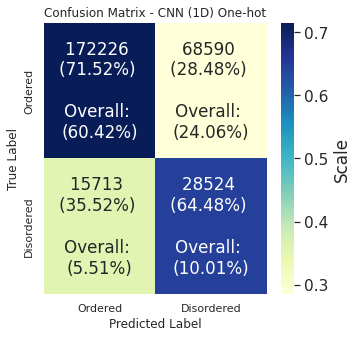

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7043)
Precision:	  tensor(0.2937)
Recall:		  tensor(0.6448)
Specificity:	  tensor(0.7152)
F1 score:	  tensor(0.4036)
MCC: 		 tensor([0.2750])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6831)
Precision averaged over sequences:	  tensor(0.3541)
Recall averaged over sequences:		  tensor(0.6109)
Specificity averaged over sequences:	  tensor(0.6369)
F1-score averaged over sequences:	  tensor(0.3748)
MCC averaged over sequences:		  tensor(0.2061)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.92      0.72      0.80    240816
Disordered Amino Acid       0.29      0.64      0.40     44237

             accuracy                           0.70    285053
            macro avg       0.61      0.68      0.60 

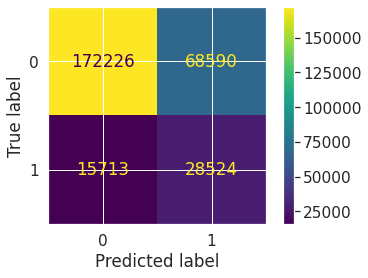

[tensor(0.6831),
 tensor(0.3541),
 tensor(0.6109),
 tensor(0.6369),
 tensor(0.3748),
 tensor(0.2061)]

In [20]:
# Creates our Confusion matrix
calculate_dataset_metrics("CNN1D1hot-cf.svg", test_loader, cnn_1d_one_hot, "CNN (1D) One-hot")
# Calulcates our metrics per sequence as required
evaluation_metrics_averaged("Test", test_loader, cnn_1d_one_hot, "CNN (1D) One-hot")

PSSM

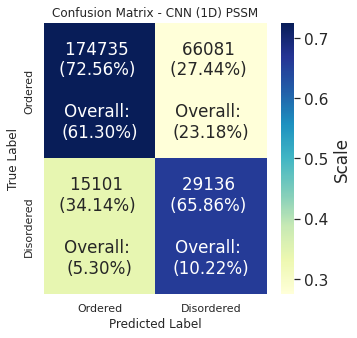

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7152)
Precision:	  tensor(0.3060)
Recall:		  tensor(0.6586)
Specificity:	  tensor(0.7256)
F1 score:	  tensor(0.4179)
MCC: 		 tensor([0.2950])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6939)
Precision averaged over sequences:	  tensor(0.3669)
Recall averaged over sequences:		  tensor(0.6514)
Specificity averaged over sequences:	  tensor(0.6436)
F1-score averaged over sequences:	  tensor(0.3980)
MCC averaged over sequences:		  tensor(0.2422)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.92      0.73      0.81    240816
Disordered Amino Acid       0.31      0.66      0.42     44237

             accuracy                           0.72    285053
            macro avg       0.61      0.69      0.61 

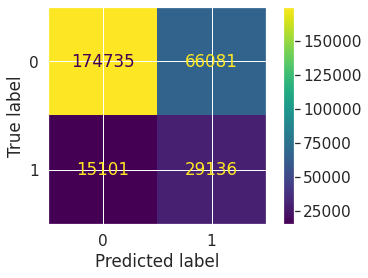

[tensor(0.6939),
 tensor(0.3669),
 tensor(0.6514),
 tensor(0.6436),
 tensor(0.3980),
 tensor(0.2422)]

In [21]:
calculate_dataset_metrics("CNN1Dpssm-cf.svg", test_pssm_loader, cnn_1d_pssm, "CNN (1D) PSSM")
evaluation_metrics_averaged("Test", test_pssm_loader, cnn_1d_pssm, "CNN (1D) PSSM")

#### 2D CNN

One-hot

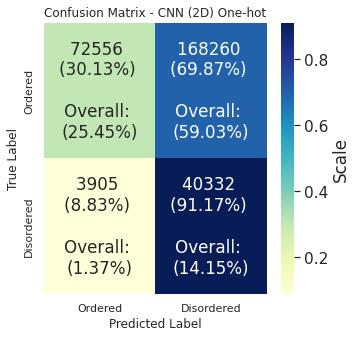

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.3960)
Precision:	  tensor(0.1934)
Recall:		  tensor(0.9117)
Specificity:	  tensor(0.3013)
F1 score:	  tensor(0.3190)
MCC: 		 tensor([0.1741])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.4277)
Precision averaged over sequences:	  tensor(0.2737)
Recall averaged over sequences:		  tensor(0.9281)
Specificity averaged over sequences:	  tensor(0.2493)
F1-score averaged over sequences:	  tensor(0.3603)
MCC averaged over sequences:		  tensor(0.1380)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.95      0.30      0.46    240816
Disordered Amino Acid       0.19      0.91      0.32     44237

             accuracy                           0.40    285053
            macro avg       0.57      0.61      0.39 

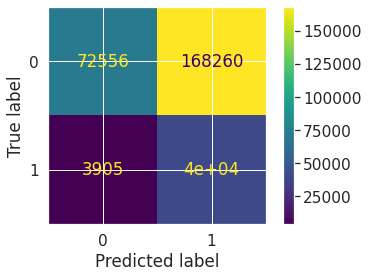

[tensor(0.4277),
 tensor(0.2737),
 tensor(0.9281),
 tensor(0.2493),
 tensor(0.3603),
 tensor(0.1380)]

In [22]:
calculate_dataset_metrics("CNN2D1hot-cf.svg", test_loader, cnn_2d_one_hot, "CNN (2D) One-hot")
evaluation_metrics_averaged("Test", test_loader, cnn_2d_one_hot, "CNN (2D) One-hot")

PSSM

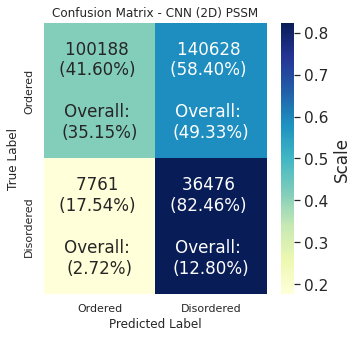

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.4794)
Precision:	  tensor(0.2060)
Recall:		  tensor(0.8246)
Specificity:	  tensor(0.4160)
F1 score:	  tensor(0.3296)
MCC: 		 tensor([0.1796])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.4953)
Precision averaged over sequences:	  tensor(0.2814)
Recall averaged over sequences:		  tensor(0.8360)
Specificity averaged over sequences:	  tensor(0.3595)
F1-score averaged over sequences:	  tensor(0.3582)
MCC averaged over sequences:		  tensor(0.1433)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.93      0.42      0.57    240816
Disordered Amino Acid       0.21      0.82      0.33     44237

             accuracy                           0.48    285053
            macro avg       0.57      0.62      0.45 

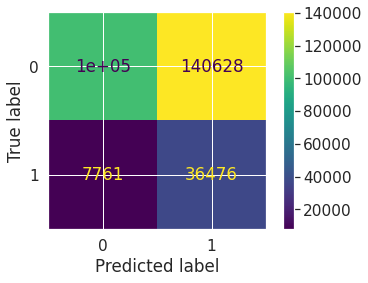

[tensor(0.4953),
 tensor(0.2814),
 tensor(0.8360),
 tensor(0.3595),
 tensor(0.3582),
 tensor(0.1433)]

In [23]:
calculate_dataset_metrics("CNN2Dpssm-cf.svg", test_pssm_loader, cnn_2d_pssm, "CNN (2D) PSSM")
evaluation_metrics_averaged("Test", test_pssm_loader, cnn_2d_pssm, "CNN (2D) PSSM")

#### LSTM

One-hot

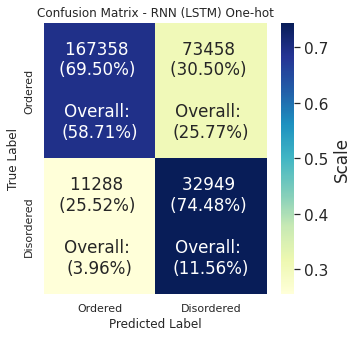

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7027)
Precision:	  tensor(0.3097)
Recall:		  tensor(0.7448)
Specificity:	  tensor(0.6950)
F1 score:	  tensor(0.4374)
MCC: 		 tensor([0.3292])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6258)
Precision averaged over sequences:	  tensor(0.3328)
Recall averaged over sequences:		  tensor(0.7648)
Specificity averaged over sequences:	  tensor(0.4977)
F1-score averaged over sequences:	  tensor(0.4033)
MCC averaged over sequences:		  tensor(0.2041)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.94      0.69      0.80    240816
Disordered Amino Acid       0.31      0.74      0.44     44237

             accuracy                           0.70    285053
            macro avg       0.62      0.72      0.62 

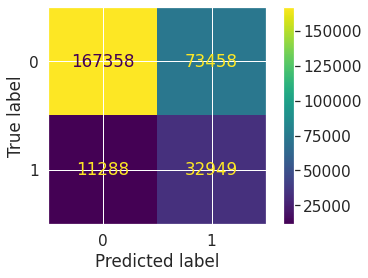

[tensor(0.6258),
 tensor(0.3328),
 tensor(0.7648),
 tensor(0.4977),
 tensor(0.4033),
 tensor(0.2041)]

In [24]:
calculate_dataset_metrics("RNN1hot-cf.svg", test_loader, rnn_one_hot, "RNN (LSTM) One-hot", rnn=True)
evaluation_metrics_averaged("Test", test_loader, rnn_one_hot, "RNN (LSTM) One-hot", rnn=True)

PSSM

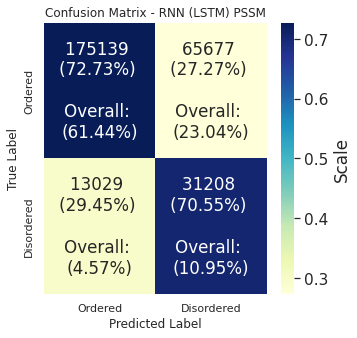

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7239)
Precision:	  tensor(0.3221)
Recall:		  tensor(0.7055)
Specificity:	  tensor(0.7273)
F1 score:	  tensor(0.4423)
MCC: 		 tensor([0.3308])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6934)
Precision averaged over sequences:	  tensor(0.3734)
Recall averaged over sequences:		  tensor(0.6759)
Specificity averaged over sequences:	  tensor(0.6285)
F1-score averaged over sequences:	  tensor(0.4101)
MCC averaged over sequences:		  tensor(0.2490)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.93      0.73      0.82    240816
Disordered Amino Acid       0.32      0.71      0.44     44237

             accuracy                           0.72    285053
            macro avg       0.63      0.72      0.63 

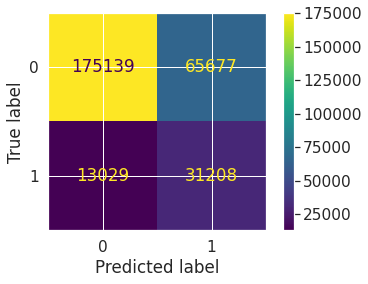

[tensor(0.6934),
 tensor(0.3734),
 tensor(0.6759),
 tensor(0.6285),
 tensor(0.4101),
 tensor(0.2490)]

In [25]:
calculate_dataset_metrics("RNNpssm-cf.svg", test_pssm_loader, rnn_pssm, "RNN (LSTM) PSSM", rnn=True)
evaluation_metrics_averaged("Test", test_pssm_loader, rnn_pssm, "RNN (LSTM) PSSM", rnn=True)

### CASP10

#### Loading data and trained models

Modified Dataset class because of how disorder label is represented.

In [26]:
class CASPDataset(Dataset):
    def __init__(self, disorder_label, vector_map, protein_sequences, ids, transform=None):
        self.disorder_prot = disorder_label
        self.vectorised_seqs = vector_map
        self.sequences = protein_sequences
        self.ids = ids
        self.tranform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.ids[idx]
        
        # Get vectorised sequence
        vectorised_protein_sequence = self.vectorised_seqs.get(acc)

        # Get protein sequence
        protein_sequence = self.sequences.get(acc)
        
        # Create order/disorder label
        disorder_label = self.disorder_prot.get(acc)

        get_dict = {'acc': acc, 'seq': vectorised_protein_sequence, 'label': disorder_label}
        return get_dict

In [27]:
def read_onehot_casp():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/casp_onehot_data.json', 'r') as infile:
    casp_onehot_map = json.load(infile)
    casp_onehot_map.update((acc, np.array(casp_onehot_map)) for acc, casp_onehot_map in casp_onehot_map.items())
    return casp_onehot_map

def read_casp_pssms():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/casp_pssm_data.json', 'r') as infile:
    pssm_map = json.load(infile)
    pssm_map.update((acc, np.array(pssm)) for acc, pssm in pssm_map.items())
    return pssm_map

def read_casp_labels():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/casp_labels.json', 'r') as infile:
    casp_labels_map = json.load(infile)
    casp_labels_map.update((acc, np.array(casp_labels_map)) for acc, casp_labels_map in casp_labels_map.items())
    return casp_labels_map

def read_casp_ids():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/casp_ids.json', 'r') as infile:
    return json.load(infile)

def read_casp_sequences():
  with open('/content/drive/My Drive/Colab Notebooks/diss_files/sequence_casp.json', 'r') as infile:
    return json.load(infile)

casp_onehot_map = read_onehot_casp()
casp_pssm_map = read_casp_pssms()
casp_labels_map = read_casp_labels()
casp_ids_dict = read_casp_ids()
casp_seqs_map = read_casp_sequences()

In [28]:
casp_dataset = CASPDataset(casp_labels_map, casp_onehot_map, casp_seqs_map, casp_ids_dict['CASP10'])
casp_loader = DataLoader(casp_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

casp_pssm_dataset = CASPDataset(casp_labels_map, casp_pssm_map, casp_seqs_map, casp_ids_dict['CASP10'])
casp_pssm_loader = DataLoader(casp_pssm_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

In [29]:
def final_read_model(model_class, model_name):
  PATH = '/content/drive/My Drive/Colab Notebooks/diss_files/pth_files/'+model_name

  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(PATH))
  return loaded_model

full_cnn_1d_one_hot = final_read_model(FCN_1D_Net(), 'full_1hot_1D_cnn_net.pth')
full_cnn_1d_pssm = final_read_model(FCN_1D_Net(), 'full_pssm_1D_cnn_net.pth')
full_cnn_2d_one_hot = final_read_model(FCN_2D_Net(), 'full_1hot_2D_cnn_net.pth')
full_cnn_2d_pssm = final_read_model(FCN_2D_Net(), 'full_pssm_2D_cnn_net.pth')
full_rnn_one_hot = final_read_model(RNN_Net(), 'full_1hot_rnn_net.pth')
full_rnn_pssm = final_read_model(RNN_Net(), 'full_pssm_rnn_net.pth')


#### CASP Evaluation - Fully trained models

In [30]:
table = []

##### 1D CNN

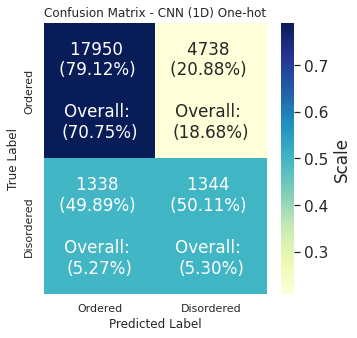

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7605)
Precision:	  tensor(0.2210)
Recall:		  tensor(0.5011)
Specificity:	  tensor(0.7912)
F1 score:	  tensor(0.3067)
MCC: 		 tensor([0.2105])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.7401)
Precision averaged over sequences:	  tensor(0.2148)
Recall averaged over sequences:		  tensor(0.4367)
Specificity averaged over sequences:	  tensor(0.7647)
F1-score averaged over sequences:	  tensor(0.2458)
MCC averaged over sequences:		  tensor(0.1587)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.93      0.79      0.86     22688
Disordered Amino Acid       0.22      0.50      0.31      2682

             accuracy                           0.76     25370
            macro avg       0.58      0.65      0.58 

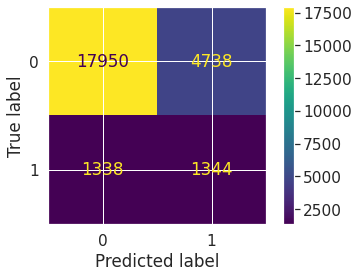

In [43]:
calculate_dataset_metrics("CASP10CNN1D1hot-cf.svg", casp_loader, full_cnn_1d_one_hot, "CNN (1D) One-hot")
val = evaluation_metrics_averaged("CASP10", casp_loader, full_cnn_1d_one_hot, "CNN (1D) One-hot")
table.append(val)

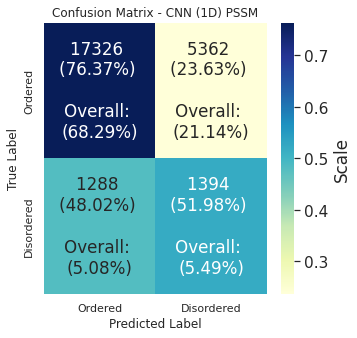

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.7379)
Precision:	  tensor(0.2063)
Recall:		  tensor(0.5198)
Specificity:	  tensor(0.7637)
F1 score:	  tensor(0.2954)
MCC: 		 tensor([0.1972])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.7045)
Precision averaged over sequences:	  tensor(0.2279)
Recall averaged over sequences:		  tensor(0.5819)
Specificity averaged over sequences:	  tensor(0.7096)
F1-score averaged over sequences:	  tensor(0.2895)
MCC averaged over sequences:		  tensor(0.1909)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.93      0.76      0.84     22688
Disordered Amino Acid       0.21      0.52      0.30      2682

             accuracy                           0.74     25370
            macro avg       0.57      0.64      0.57 

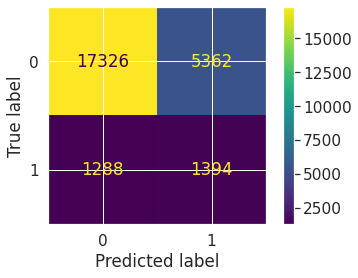

In [44]:
calculate_dataset_metrics("CASP10CNN1Dpssm-cf.svg", casp_pssm_loader, full_cnn_1d_pssm, "CNN (1D) PSSM")
val = evaluation_metrics_averaged("CASP10", casp_pssm_loader, full_cnn_1d_pssm, "CNN (1D) PSSM")
table.append(val)

##### 2D CNN

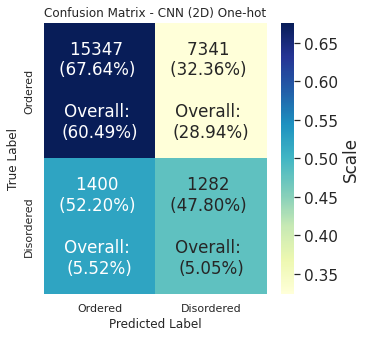

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6555)
Precision:	  tensor(0.1487)
Recall:		  tensor(0.4780)
Specificity:	  tensor(0.6764)
F1 score:	  tensor(0.2268)
MCC: 		 tensor([0.1003])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6351)
Precision averaged over sequences:	  tensor(0.1766)
Recall averaged over sequences:		  tensor(0.5551)
Specificity averaged over sequences:	  tensor(0.6466)
F1-score averaged over sequences:	  tensor(0.2256)
MCC averaged over sequences:		  tensor(0.1195)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.92      0.68      0.78     22688
Disordered Amino Acid       0.15      0.48      0.23      2682

             accuracy                           0.66     25370
            macro avg       0.53      0.58      0.50 

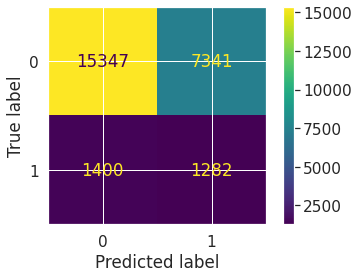

In [45]:
calculate_dataset_metrics("CASP10CNN2D1hot-cf.svg", casp_loader, full_cnn_2d_one_hot, "CNN (2D) One-hot")
val = evaluation_metrics_averaged("CASP10", casp_loader, full_cnn_2d_one_hot, "CNN (2D) One-hot")
table.append(val)

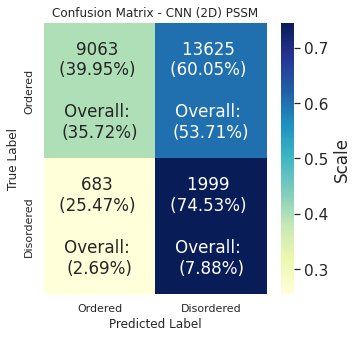

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.4360)
Precision:	  tensor(0.1279)
Recall:		  tensor(0.7453)
Specificity:	  tensor(0.3995)
F1 score:	  tensor(0.2184)
MCC: 		 tensor([0.0915])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.4461)
Precision averaged over sequences:	  tensor(0.1560)
Recall averaged over sequences:		  tensor(0.7758)
Specificity averaged over sequences:	  tensor(0.3967)
F1-score averaged over sequences:	  tensor(0.2318)
MCC averaged over sequences:		  tensor(0.0982)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.93      0.40      0.56     22688
Disordered Amino Acid       0.13      0.75      0.22      2682

             accuracy                           0.44     25370
            macro avg       0.53      0.57      0.39 

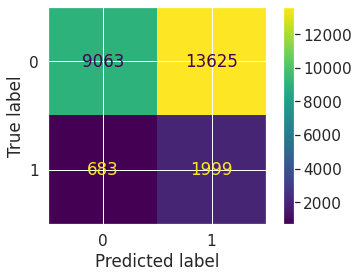

In [46]:
calculate_dataset_metrics("CASP10CNN2Dpssm-cf.svg", casp_pssm_loader, full_cnn_2d_pssm, "CNN (2D) PSSM")
val = evaluation_metrics_averaged("CASP10", casp_pssm_loader, full_cnn_2d_pssm, "CNN (2D) PSSM")
table.append(val)

##### RNN

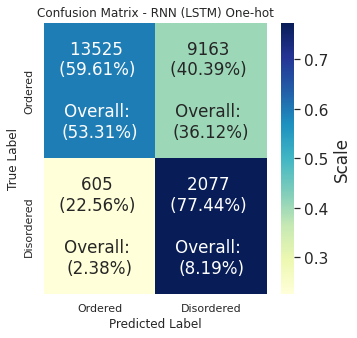

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6150)
Precision:	  tensor(0.1848)
Recall:		  tensor(0.7744)
Specificity:	  tensor(0.5961)
F1 score:	  tensor(0.2984)
MCC: 		 tensor([0.2294])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.5414)
Precision averaged over sequences:	  tensor(0.1959)
Recall averaged over sequences:		  tensor(0.7891)
Specificity averaged over sequences:	  tensor(0.4869)
F1-score averaged over sequences:	  tensor(0.2775)
MCC averaged over sequences:		  tensor(0.1636)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.96      0.60      0.73     22688
Disordered Amino Acid       0.18      0.77      0.30      2682

             accuracy                           0.61     25370
            macro avg       0.57      0.69      0.52 

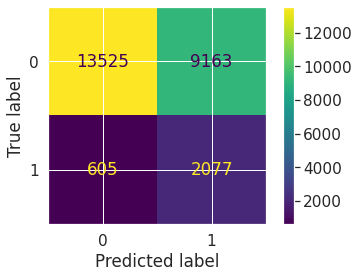

In [47]:
calculate_dataset_metrics("CASP10RNN1hot-cf.svg", casp_loader, full_rnn_one_hot, "RNN (LSTM) One-hot", rnn=True)
val = evaluation_metrics_averaged("CASP10", casp_loader, full_rnn_one_hot, "RNN (LSTM) One-hot", rnn=True)
table.append(val)

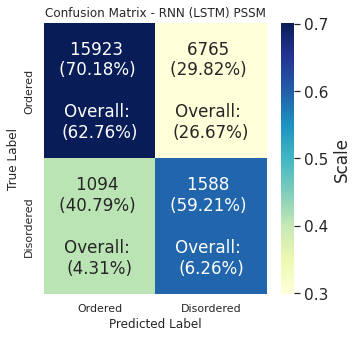

Considering our metrics using the sums of all TP, TN, FP, FN values over the entire dataset.
Accuracy:	  tensor(0.6902)
Precision:	  tensor(0.1901)
Recall:		  tensor(0.5921)
Specificity:	  tensor(0.7018)
F1 score:	  tensor(0.2878)
MCC: 		 tensor([0.1923])




Considering our metrics as an average of these metrics per sequence over the entire dataset.
Accuracy averaged over sequences:	  tensor(0.6596)
Precision averaged over sequences:	  tensor(0.2337)
Recall averaged over sequences:		  tensor(0.6108)
Specificity averaged over sequences:	  tensor(0.6479)
F1-score averaged over sequences:	  tensor(0.2896)
MCC averaged over sequences:		  tensor(0.1809)



Detailed classification report.
                       precision    recall  f1-score   support

   Ordered Amino Acid       0.94      0.70      0.80     22688
Disordered Amino Acid       0.19      0.59      0.29      2682

             accuracy                           0.69     25370
            macro avg       0.56      0.65      0.54 

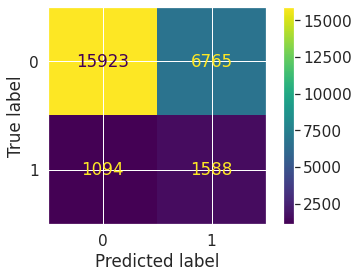

In [48]:
calculate_dataset_metrics("CASP10RNNpssm-cf.svg", casp_pssm_loader, full_rnn_pssm, "RNN (LSTM) PSSM", rnn=True)
val = evaluation_metrics_averaged("CASP10", casp_pssm_loader, full_rnn_pssm, "RNN (LSTM) PSSM", rnn=True)
table.append(val)

In [42]:
with open("output.csv", "w") as f:
  for row in table:
    line = ','.join([str(round(float(elem), 4)) for elem in row])
    f.write(line + '\n')

#### ROC

##### Test Dataset

In [49]:
tpr_1, fpr_1, thresholds_1, auc1 = roc("CASP10", test_loader, cnn_1d_one_hot, "RNN (LSTM) PSSM")


In [51]:
tpr_1, fpr_1, thresholds_1, auc1 = roc("TEST", test_loader, cnn_1d_one_hot, "CNN 1D")
tpr_2, fpr_2, thresholds_2, auc2 = roc("TEST", test_pssm_loader, cnn_1d_pssm, "CNN 1D")
tpr_3, fpr_3, thresholds_3, auc3 = roc("TEST", test_loader, cnn_2d_one_hot, "CNN 2D")
tpr_4, fpr_4, thresholds_4, auc4 = roc("TEST", test_pssm_loader, cnn_2d_pssm, "CNN 2D")
tpr_5, fpr_5, thresholds_5, auc5 = roc("TEST", test_loader, rnn_one_hot, "RNN (LSTM)", rnn=True)
tpr_6, fpr_6, thresholds_6, auc6 = roc("TEST", test_pssm_loader, rnn_pssm, "RNN (LSTM)", rnn=True)

tpr = [tpr_1, tpr_2, tpr_3, tpr_4, tpr_5, tpr_6]
fpr = [fpr_1, fpr_2, fpr_3, fpr_4, fpr_5, fpr_6]
auc_scores = [auc1, auc2, auc3, auc4, auc5, auc6]

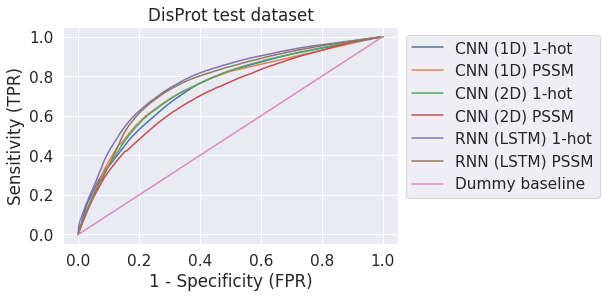

In [52]:
plt.plot(fpr_1, tpr_1, label='CNN (1D) 1-hot')
plt.plot(fpr_2, tpr_2, label='CNN (1D) PSSM')
plt.plot(fpr_3, tpr_3, label='CNN (2D) 1-hot')
plt.plot(fpr_4, tpr_4, label='CNN (2D) PSSM')
plt.plot(fpr_5, tpr_5, label='RNN (LSTM) 1-hot')
plt.plot(fpr_6, tpr_6, label='RNN (LSTM) PSSM')
plt.plot([0, 1], [0, 1], label="Dummy baseline")
plt.title('DisProt test dataset')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
#plt.savefig("DisProtROC.svg", bbox_inches='tight', format='svg', dpi=1200)
plt.show()

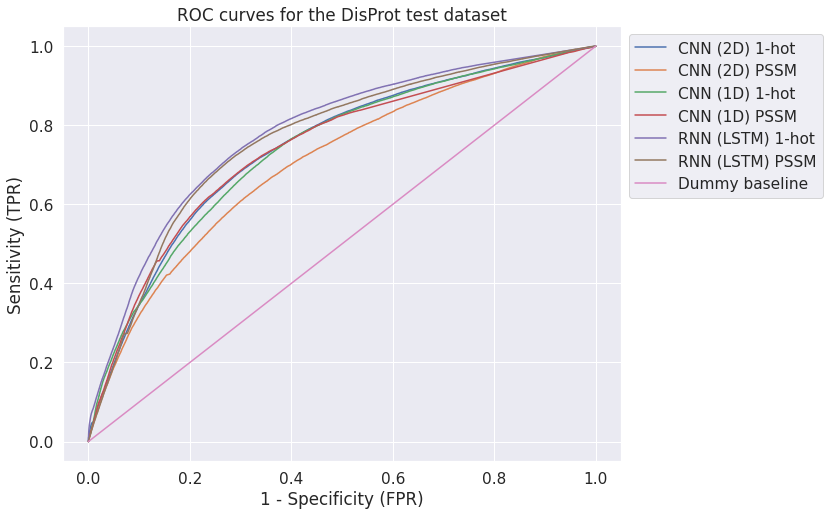

In [53]:
# For dissertation image
fig = plt.figure(1, figsize=(10.0, 8.0))#(6.4, 4.8))
plt.plot(fpr_3, tpr_3, label='CNN (2D) 1-hot')
plt.plot(fpr_4, tpr_4, label='CNN (2D) PSSM')
plt.plot(fpr_1, tpr_1, label='CNN (1D) 1-hot')
plt.plot(fpr_2, tpr_2, label='CNN (1D) PSSM')
plt.plot(fpr_5, tpr_5, label='RNN (LSTM) 1-hot')
plt.plot(fpr_6, tpr_6, label='RNN (LSTM) PSSM')
plt.plot([0, 1], [0, 1], label="Dummy baseline")
plt.title('ROC curves for the DisProt test dataset')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.savefig("DisProtROC.svg", bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [54]:
auc_scores

[0.7378623741755894,
 0.7402635607226677,
 0.7425769486698259,
 0.7043016415893657,
 0.7794405633710932,
 0.7635059282213486]

##### CASP dataset

In [55]:
tpr_1, fpr_1, thresholds_1, auc1 = roc("CASP10", casp_loader, full_cnn_1d_one_hot, "RNN (LSTM) PSSM")
tpr_2, fpr_2, thresholds_2, auc2 = roc("CASP10", casp_pssm_loader, full_cnn_1d_pssm, "RNN (LSTM) PSSM")
tpr_3, fpr_3, thresholds_3, auc3 = roc("CASP10", casp_loader, full_cnn_2d_one_hot, "RNN (LSTM) PSSM")
tpr_4, fpr_4, thresholds_4, auc4 = roc("CASP10", casp_pssm_loader, full_cnn_2d_pssm, "RNN (LSTM) PSSM")
tpr_5, fpr_5, thresholds_5, auc5 = roc("CASP10", casp_loader, full_rnn_one_hot, "RNN (LSTM) PSSM", rnn=True)
tpr_6, fpr_6, thresholds_6, auc6 = roc("CASP10", casp_pssm_loader, full_rnn_pssm, "RNN (LSTM) PSSM", rnn=True)

tpr = [tpr_1, tpr_2, tpr_3, tpr_4, tpr_5, tpr_6]
fpr = [fpr_1, fpr_2, fpr_3, fpr_4, fpr_5, fpr_6]

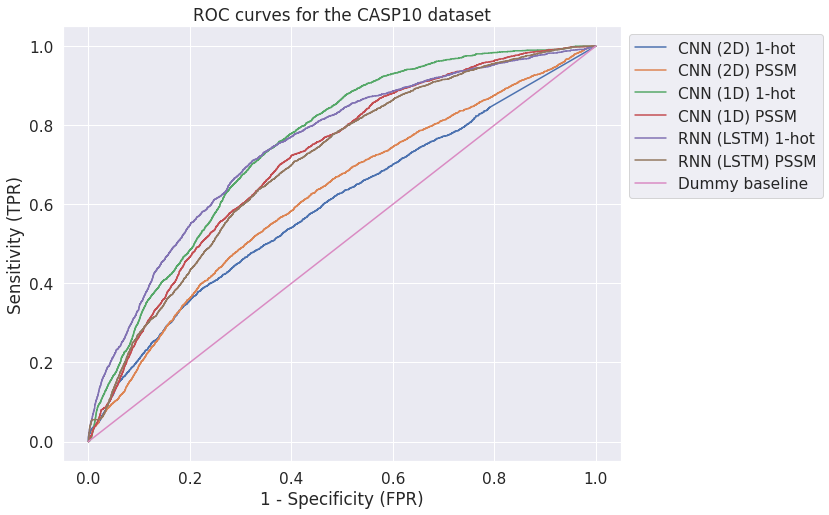

In [56]:
fig = plt.figure(1, figsize=(10.0, 8.0))#(6.4, 4.8))
plt.plot(fpr_3, tpr_3, label='CNN (2D) 1-hot')
plt.plot(fpr_4, tpr_4, label='CNN (2D) PSSM')
plt.plot(fpr_1, tpr_1, label='CNN (1D) 1-hot')
plt.plot(fpr_2, tpr_2, label='CNN (1D) PSSM')
plt.plot(fpr_5, tpr_5, label='RNN (LSTM) 1-hot')
plt.plot(fpr_6, tpr_6, label='RNN (LSTM) PSSM')
plt.plot([0, 1], [0, 1], label="Dummy baseline")
plt.title('ROC curves for the CASP10 dataset')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.savefig("CASPROC.svg", bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [69]:
tpr_r = np.round(tpr_6, 1)

thresholds_6[tpr_r == 0.8]

array([0.3757471 , 0.3756185 , 0.37561512, 0.3754336 , 0.375379  ,
       0.37520933, 0.3752019 , 0.37491426, 0.37481377, 0.37457216,
       0.37455875, 0.3745491 , 0.37452954, 0.37445104, 0.37443778,
       0.37442023, 0.37440225, 0.37426007, 0.3742216 , 0.37378532,
       0.37377086, 0.3735528 , 0.3735279 , 0.37309486, 0.37306833,
       0.37297437, 0.3729715 , 0.37278485, 0.3727758 , 0.37275067,
       0.37273842, 0.37258202, 0.37253618, 0.37133732, 0.37132475,
       0.37131408, 0.37129492, 0.3712037 , 0.3711995 , 0.37080202,
       0.3707994 , 0.37053055, 0.3704738 , 0.3704678 , 0.3704198 ,
       0.37011537, 0.3700616 , 0.3696464 , 0.36954644, 0.3694657 ,
       0.3694221 , 0.3693451 , 0.3693112 , 0.36906692, 0.36906064,
       0.36799037, 0.3679727 , 0.36773917, 0.3677332 , 0.3677095 ,
       0.36769724, 0.36767387, 0.367661  , 0.36759827, 0.36758298,
       0.36732608, 0.36732376, 0.3667189 , 0.36670175, 0.36651942,
       0.36647   , 0.3661487 , 0.36609527, 0.36606756, 0.36599

##### Stats

In [60]:
from scipy.stats import mannwhitneyu, wilcoxon
from sklearn.metrics import roc_auc_score, matthews_corrcoef


Trying to subsample MCC values given subsets as literature discusses.
Also getting every MCC value returned. Performing non-parametric tests on these.

In [66]:
def auc_lots(name, dataset, model, title, conf_mat=True, rnn=False):

  mccs = []

  model.eval()
  for seq in dataset:
    input_seq = seq.get('seq')
    if rnn:
      input_seq = torch.einsum('ijk->ikj', input_seq)
    input_seq = input_seq.type(torch.FloatTensor)
    true_label = seq.get('label')
    true_label = true_label.type(torch.FloatTensor)

    with torch.no_grad():
      if rnn:
        predicted_label, _ = model(input_seq)
      else:
        predicted_label = model(input_seq)

    predicted_label = torch.sigmoid(predicted_label)
    predicted_label = torch.squeeze(predicted_label)
    true_label = torch.squeeze(true_label)
    pred_lab = pred_round(predicted_label)
    
    mcc = matthews_corrcoef(true_label, pred_lab)
    mccs.append(mcc)
  
  return np.array(mccs)
  #return predicted_label, true_label

def subsets(my_array):
  # Assuming your numpy array is named 'my_array'
  array_len = len(my_array)
  subset_len = int(0.8 * array_len)  # Length of each subset

  print(subset_len)

  # Create 100 subsets
  num_subsets = 100
  subsets = []
  for i in range(num_subsets):
      subset_idx = np.random.choice(range(array_len), size=subset_len, replace=False)
      #subset = my_array[subset_idx]
      subsets.append(subset_idx)

  return subsets #np.mean(subsets, axis=1)

def get_subset(my_array, subset):
  subs = []
  for sub in subset:
    subs.append(my_array[sub])

  return np.mean(subs, axis=1)


m1 = auc_lots("CASP10", test_loader, cnn_2d_one_hot, "RNN (LSTM) PSSM")
m2 = auc_lots("CASP10", test_pssm_loader, rnn_pssm, "RNN (LSTM) PSSM", rnn=True)


#sub_tot = subsets(m1)
#sub_m1 = get_subset(m1, sub_tot)
#sub_m2 = get_subset(m2, sub_tot)



In [68]:
# Using MCC values

# Wilcoxon
res = wilcoxon(m1, m2, alternative='less')
print(res)

# Mann Whitney
_, p_value = mannwhitneyu(m1, m2, alternative='less')
print(p_value)

WilcoxonResult(statistic=21866.0, pvalue=9.515495257309483e-19)
2.9793914202174884e-06
